In [1]:
import pickle
import plotly.express as px
from plotly.graph_objs import Figure
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Utility Functions

In [2]:
def create_figure(df, x_column, y_column) -> Figure:
    x_data = df[x_column]
    y_data = df[y_column]

    min_value = y_data.min()
    max_value = y_data.max()
    season_value = y_data.iloc[-1]
    
    fig = px.line(x=x_data, y=y_data, markers=True)
    fig.update_layout(
        xaxis_title=x_column,
        yaxis_title=y_column,
        title=f'{df['Name'].iloc[0]} {y_column} over time'
    )
    fig.add_hline(y=min_value, line_dash="dot", line_color="black", annotation_text=f'Min: {min_value}', annotation_position="bottom right")
    fig.add_hline(y=max_value, line_dash="dot", line_color="black", annotation_text=f'Max: {max_value}', annotation_position="top right")
    
    fig.add_annotation(text=f"End of Season Value {season_value}", x=x_data.iloc[-12], y=season_value-season_value*0.05, showarrow=False)
    
    fig.update_yaxes(nticks=20)
    return fig

In [3]:
def compute_league_variance(dfs:dict):
    """
    Compute the season stat variance of each stat across the league 
    """
    stat_columns = ['BA','OBP','SLG','OPS','wOBA','K%','BB%','ISO','wRC+']
    player_values = {}
    for key, df in dfs.items():
        player_values[key] = df[stat_columns].iloc[-1].to_dict()
    
    return pd.DataFrame(player_values).T

# Stability Algorithms

In [4]:
def sliding_window_stability(dfs:dict, stat:str, thresholds:dict) -> dict:
    """
    Works by computing the standard deviation for a given stat over a sliding window of games
    so that we can see how a player's performance stabilizes over time
    """
    window_size = 10 # games
    window_lag = 5
    lagged_std = 0
    log = []
    stability_columns = [f'Season {stat}', f'Game Threshold {stat}', f'{stat} Mean', f'{stat} Std']
    stability = pd.DataFrame(index=dfs.keys(), columns=stability_columns).fillna(-1)

    for player_id, df in dfs.items():
        i = 0
        stability.at[player_id,f'Season {stat}'] = df[stat].iloc[-1]
        stability.at[player_id,f'Game Threshold {stat}'] = df['G'].iloc[-1]
        stability.at[player_id,f'{stat} Mean'] = -1
        stability.at[player_id,f'{stat} Std'] = -1

        while i+window_size < len(df):
            window_stats = df.iloc[i:i+window_size][stat]
            window_std = window_stats.std()
            window_mean = window_stats.mean()
            mean_diff = abs(window_mean - stability.at[player_id,f'Season {stat}'])
            window_std_roc = abs(window_std - lagged_std)

            if player_id == 641355:
                log.append(f"Games: {i+window_size}, Window Mean: {round(window_mean,3)}, Window Std: {round(window_std,4)},\
                           Mean Diff: {round(mean_diff,3)}, Std ROC: {round(window_std_roc,4)}")

            if window_std < thresholds[stat]['std'] and mean_diff < thresholds[stat]['mean'] and window_std_roc < thresholds[stat]['std_roc']:
                stability.at[player_id, f'Game Threshold {stat}'] = i+window_size
                stability.at[player_id, f'{stat} Mean'] = window_mean
                stability.at[player_id, f'{stat} Std'] = window_std
                break
            i+=1
            # if i-window_lag > 0:
            lagged_window = df.iloc[i-window_lag:i-window_lag+window_size][stat]
            lagged_std = lagged_window.std()

    return stability, log

The above code computes stability off of when at a certain point a window gets below a standard deviation threshhold and a difference between the current value and the season mean. I worry that this is not a comprehensive way to measure stability since you could essentially get lucky by finding a temporarily stable period of time that is relatively close to the player's season value. 

Ideas to get around this:
* After you find the first window match (let's say at 65 games), compute how many "false" windows follow it (how many don't satisfy the threshold criteria). If the number of false windows is below another threshold, then keep the first window match, else move to the next one
* Create a measure of the std deviation rate of change - negative values means the value is getting more stable, then as it approaches 0 it's getting as stable as it will get

Will start by implementing the second option

# Analysis

In [5]:
player_dfs_2023 = pickle.load(open('2023_player_dfs.pkl', 'rb'))
player_dfs_2023.keys()

dict_keys([682928, 547989, 660670, 642715, 645277, 624413, 641313, 606115, 571448, 668227, 650333, 595879, 605137, 641355, 643217, 605141, 666182, 593428, 664761, 608324, 600869, 592192, 682998, 592206, 656305, 661388, 621043, 641487, 630105, 605204, 650559, 646240, 553869, 650490, 592273, 669242, 642731, 664034, 518692, 670770, 666969, 665926, 502671, 663757, 665489, 666971, 664023, 671739, 663647, 669720, 683002, 571771, 606192, 663538, 663697, 673962, 673490, 680757, 518934, 596019, 663993, 592518, 606466, 656716, 641857, 643446, 669004, 608841, 593160, 571970, 607043, 663457, 660271, 621566, 681546, 542303, 670623, 665161, 521692, 663728, 608070, 592663, 592669, 668804, 663586, 673357, 677594, 667670, 642708, 660688, 668939, 467793, 623993, 656941, 608369, 543760, 642086, 669257, 624585, 665742, 543807, 668715, 663886, 681082, 664702, 553993, 669261, 621020, 657041, 679529, 650402, 678662, 663656, 457759, 607208, 662139, 683734, 657077, 663837, 683011, 664774, 572233, 677951, 59288

In [6]:
df = compute_league_variance(player_dfs_2023)
df.describe()

,BA,OBP,SLG,OPS,wOBA,K%,BB%,ISO,wRC+
count,133.000000,133.000000,133.000000,133.000000,133.000000,133.000000,133.000000,133.000000,133.000000
mean,0.261774,0.334398,0.444383,0.778714,0.417922,0.207879,0.089364,0.182616,17.833764
std,0.025463,0.029555,0.060298,0.081808,0.044471,0.052094,0.029938,0.050986,3.557708
min,0.197000,0.267000,0.296000,0.582000,0.297691,0.055105,0.032759,0.050710,8.215267
25%,0.248000,0.315000,0.407000,0.717000,0.386575,0.170608,0.065123,0.153518,15.326027
50%,0.262000,0.328000,0.441000,0.778000,0.417373,0.209756,0.088123,0.178752,17.789855
75%,0.275000,0.352000,0.475000,0.818000,0.441756,0.238532,0.105008,0.209480,19.740458
max,0.354000,0.416000,0.654000,1.066000,0.559221,0.326996,0.186441,0.350101,29.137716


In [7]:
# Need more standardized method to define the thresholds
thresholds = {
    'BA': {
        'std': 0.01,
        'std_roc': 0.002,
        'mean': 0.01
    },
    'OBP': {
        'std': 0.015,
        'std_roc': 0.0025,
        'mean': 0.015
    },
    'SLG': {
        'std': 0.03,
        'std_roc': 0.006,
        'mean': 0.03
    },
    'OPS': {
        'std': 0.04,
        'std_roc': 0.008,
        'mean': 0.04
    },
    'wOBA': {
        'std': 0.02,
        'std_roc': 0.004,
        'mean': 0.02
    },
    'K%': {
        'std': 0.025,
        'std_roc': 0.001,
        'mean': 0.025
    },
    'BB%': {
        'std': 0.015,
        'std_roc': 0.001,
        'mean': 0.015 
    },
    'ISO': {
        'std': 0.025,
        'std_roc': 0.001,
        'mean': 0.025
    },
    'wRC+': {
        'std': 1.5,
        'std_roc': 0.15,
        'mean': 1.5
    }
}

In [8]:
stability_df = pd.DataFrame()
stat_columns = ['BA','OBP','SLG','OPS','wOBA','K%','BB%','ISO','wRC+']
for stat in stat_columns:
    print(f"Computing stability for {stat}")
    stability, log = sliding_window_stability(player_dfs_2023, stat, thresholds)
    stability_df = pd.concat([stability_df, stability], axis=1)

Computing stability for BA
Computing stability for OBP
Computing stability for SLG
Computing stability for OPS
Computing stability for wOBA
Computing stability for K%
Computing stability for BB%
Computing stability for ISO
Computing stability for wRC+


In [9]:
stability_df

,Season BA,Game Threshold BA,BA Mean,BA Std,Season OBP,Game Threshold OBP,OBP Mean,OBP Std,Season SLG,Game Threshold SLG,...,BB% Mean,BB% Std,Season ISO,Game Threshold ISO,ISO Mean,ISO Std,Season wRC+,Game Threshold wRC+,wRC+ Mean,wRC+ Std
682928,0.245,42,0.2445,0.007517,0.3,23,0.2965,0.009107,0.412,43,...,0.061158,0.006906,0.166963,44,0.147765,0.014121,15.244444,56,14.210012,0.571451
547989,0.237,29,0.2449,0.006641,0.296,28,0.2844,0.01048,0.383,102,...,0.059802,0.007284,0.146296,126,0.123637,0.00631,13.426644,126,11.981439,0.511012
660670,0.338,39,0.3474,0.005719,0.416,55,0.4147,0.00882,0.596,33,...,0.11967,0.008715,0.258165,54,0.242841,0.009192,26.997814,28,26.746327,0.852148
642715,0.217,42,0.2254,0.007763,0.31,41,0.3229,0.009327,0.407,34,...,0.126025,0.007382,0.189873,26,0.198045,0.015132,15.783359,42,14.575921,1.076936
645277,0.28,141,0.2723,0.004001,0.336,115,0.3215,0.003274,0.513,48,...,0.05714,0.003596,0.233221,47,0.236947,0.009599,20.904559,48,19.523249,0.831126
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
665750,0.266,97,0.2758,0.002616,0.312,91,0.326,0.004163,0.421,31,...,0.075283,0.014456,0.154599,22,0.142231,0.018068,16.102527,32,17.439483,1.031471
673548,0.285,45,0.2846,0.006484,0.357,27,0.3445,0.010752,0.485,45,...,0.097483,0.00807,0.2,49,0.181978,0.010502,20.537931,51,19.285131,1.200411
665487,0.257,42,0.2533,0.006945,0.322,23,0.3168,0.012874,0.449,35,...,0.082605,0.009581,0.191304,28,0.211837,0.011904,17.972283,30,18.998596,1.15336
672580,0.272,71,0.2755,0.002461,0.323,36,0.3225,0.004927,0.358,23,...,0.086962,0.003824,0.086207,20,0.082955,0.009357,12.373592,72,13.871069,0.218511


In [11]:
player_key = 641355
fig = create_figure(player_dfs_2023[player_key], x_column='G', y_column='OPS')
fig.add_vline(x=stability_df.loc[player_key]['Game Threshold OPS'], line_dash="dot", line_color="black", annotation_text=f'OPS Stabilized (Est: {round(stability_df.loc[player_key]['OPS Mean'],3)})', annotation_position="bottom right")
fig.show()

In [12]:
fig = create_figure(player_dfs_2023[player_key], x_column='G', y_column='K%')
fig.add_vline(x=stability_df.loc[player_key]['Game Threshold K%'], line_dash="dot", line_color="black", annotation_text=f'K% Stabilized (Est: {round(stability_df.loc[player_key]['K% Mean'],3)})', annotation_position="bottom right")
fig.show()

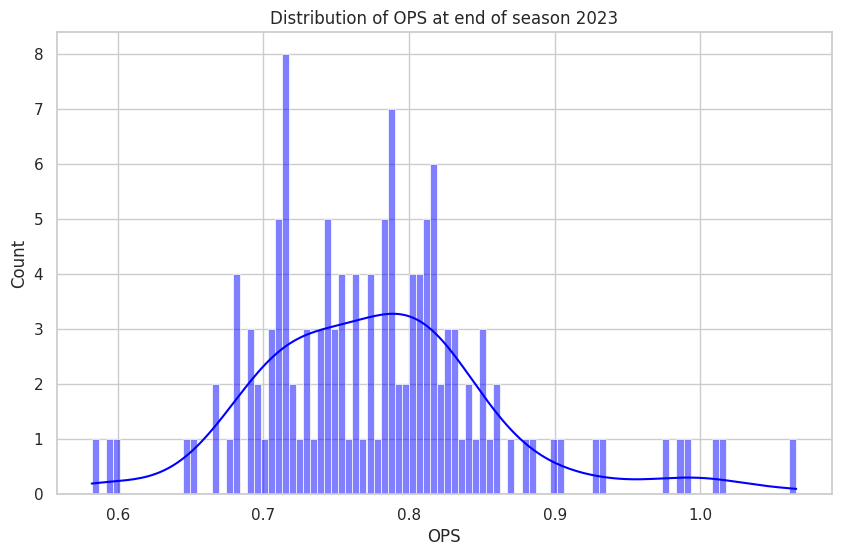

In [13]:
# Plot distribution of OPS for all players in player_dfs_2023
sns.set(style="whitegrid")

ops = [df['OPS'].iloc[-1] for df in player_dfs_2023.values()]
plt.figure(figsize=(10,6))
sns.histplot(ops, kde=True, bins=100, color='blue')
plt.title('Distribution of OPS at end of season 2023')
plt.xlabel('OPS')
plt.show()
